In [91]:
from functools import reduce
import os

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql import SparkSession
from pyspark.sql import DataFrame
from pyspark.sql.types import FloatType, StructType, IntegerType, DoubleType, DateType
from pyspark.sql import functions as F
from pyspark.sql.functions import col, monotonically_increasing_id, to_date, desc

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score
from pyspark.ml.feature import StringIndexer


In [2]:
spark = SparkSession.builder.appName("FinalAssigment").config("spark.driver.memory", "50g").getOrCreate()

In [3]:
df = spark.read.csv(["C:\\Users\\Evgenija\\Desktop\\Proccesing Big Data\\Dataset_Final\\DataSet_final\\DimAccount.csv",
                     "C:\\Users\\Evgenija\\Desktop\\Proccesing Big Data\\Dataset_Final\\DataSet_final\\DimCurrency.csv", 
                     "C:\\Users\\Evgenija\\Desktop\\Proccesing Big Data\\Dataset_Final\\DataSet_final\\DimCustomer.csv", 
                    "C:\\Users\\Evgenija\\Desktop\\Proccesing Big Data\\Dataset_Final\\DataSet_final\\DimDate.csv",
                    "C:\\Users\\Evgenija\\Desktop\\Proccesing Big Data\\Dataset_Final\\DataSet_final\\DimDepartmentGroup.csv",
                    "C:\\Users\\Evgenija\\Desktop\\Proccesing Big Data\\Dataset_Final\\DataSet_final\\DimGeography.csv",
                     "C:\\Users\\Evgenija\\Desktop\\Proccesing Big Data\\Dataset_Final\\DataSet_final\\DimOrganization.csv",
                    "C:\\Users\\Evgenija\\Desktop\\Proccesing Big Data\\Dataset_Final\\DataSet_final\\DimProduct.csv",
                    "C:\\Users\\Evgenija\\Desktop\\Proccesing Big Data\\Dataset_Final\\DataSet_final\\DimProductCategory.csv",
                    "C:\\Users\\Evgenija\\Desktop\\Proccesing Big Data\\Dataset_Final\\DataSet_final\\DimProductSubcategory.csv",
                    "C:\\Users\\Evgenija\\Desktop\\Proccesing Big Data\\Dataset_Final\\DataSet_final\\DimPromotion.csv",
                    "C:\\Users\\Evgenija\\Desktop\\Proccesing Big Data\\Dataset_Final\\DataSet_final\\DimReseller.csv",
                    "C:\\Users\\Evgenija\\Desktop\\Proccesing Big Data\\Dataset_Final\\DataSet_final\\DimSalesReason.csv",
                    "C:\\Users\\Evgenija\\Desktop\\Proccesing Big Data\\Dataset_Final\\DataSet_final\\DimSalesTerritory.csv",
                    "C:\\Users\\Evgenija\\Desktop\\Proccesing Big Data\\Dataset_Final\\DataSet_final\\DimScenario.csv",
                    "C:\\Users\\Evgenija\\Desktop\\Proccesing Big Data\\Dataset_Final\\DataSet_final\\FactCallCenter.csv",
                    "C:\\Users\\Evgenija\\Desktop\\Proccesing Big Data\\Dataset_Final\\DataSet_final\\FactCurrencyRate.csv",
                    "C:\\Users\\Evgenija\\Desktop\\Proccesing Big Data\\Dataset_Final\\DataSet_final\\FactFinance.csv",
                    "C:\\Users\\Evgenija\\Desktop\\Proccesing Big Data\\Dataset_Final\\DataSet_final\\FactInternetSales.csv",
                    "C:\\Users\\Evgenija\\Desktop\\Proccesing Big Data\\Dataset_Final\\DataSet_final\\FactSalesTargets.csv"],
                    header=True, inferSchema=True)

In [4]:
df.show()

+----------+------------+----------+-----------+-----------+------------+-----------+-----------------+----------------+--------------------+--------------+-------------+---------+--------------+--------------------+--------------+-------------------+----------------+-----------+--------+-------+---------------------+----------------+--------------------+--------------------+--------------------+
|ProductKey|OrderDateKey|DueDateKey|ShipDateKey|CustomerKey|PromotionKey|CurrencyKey|SalesTerritoryKey|SalesOrderNumber|SalesOrderLineNumber|RevisionNumber|OrderQuantity|UnitPrice|ExtendedAmount|UnitPriceDiscountPct|DiscountAmount|ProductStandardCost|TotalProductCost|SalesAmount|  TaxAmt|Freight|CarrierTrackingNumber|CustomerPONumber|           OrderDate|             DueDate|            ShipDate|
+----------+------------+----------+-----------+-----------+------------+-----------+-----------------+----------------+--------------------+--------------+-------------+---------+--------------+-----

In [5]:
df.printSchema()

root
 |-- ProductKey: string (nullable = true)
 |-- OrderDateKey: string (nullable = true)
 |-- DueDateKey: string (nullable = true)
 |-- ShipDateKey: string (nullable = true)
 |-- CustomerKey: string (nullable = true)
 |-- PromotionKey: string (nullable = true)
 |-- CurrencyKey: string (nullable = true)
 |-- SalesTerritoryKey: string (nullable = true)
 |-- SalesOrderNumber: string (nullable = true)
 |-- SalesOrderLineNumber: string (nullable = true)
 |-- RevisionNumber: string (nullable = true)
 |-- OrderQuantity: string (nullable = true)
 |-- UnitPrice: string (nullable = true)
 |-- ExtendedAmount: string (nullable = true)
 |-- UnitPriceDiscountPct: string (nullable = true)
 |-- DiscountAmount: string (nullable = true)
 |-- ProductStandardCost: string (nullable = true)
 |-- TotalProductCost: string (nullable = true)
 |-- SalesAmount: string (nullable = true)
 |-- TaxAmt: string (nullable = true)
 |-- Freight: string (nullable = true)
 |-- CarrierTrackingNumber: string (nullable = tru

In [6]:
df.describe().show()

+-------+------------------+--------------------+--------------------+--------------------+------------------+-----------------+------------------+------------------+------------------+--------------------+------------------+-----------------+--------------------+-----------------+--------------------+------------------+-------------------+------------------+------------------+------------------+------------------+---------------------+------------------+--------------------+--------------------+-----------------+
|summary|        ProductKey|        OrderDateKey|          DueDateKey|         ShipDateKey|       CustomerKey|     PromotionKey|       CurrencyKey| SalesTerritoryKey|  SalesOrderNumber|SalesOrderLineNumber|    RevisionNumber|    OrderQuantity|           UnitPrice|   ExtendedAmount|UnitPriceDiscountPct|    DiscountAmount|ProductStandardCost|  TotalProductCost|       SalesAmount|            TaxAmt|           Freight|CarrierTrackingNumber|  CustomerPONumber|           OrderDate|

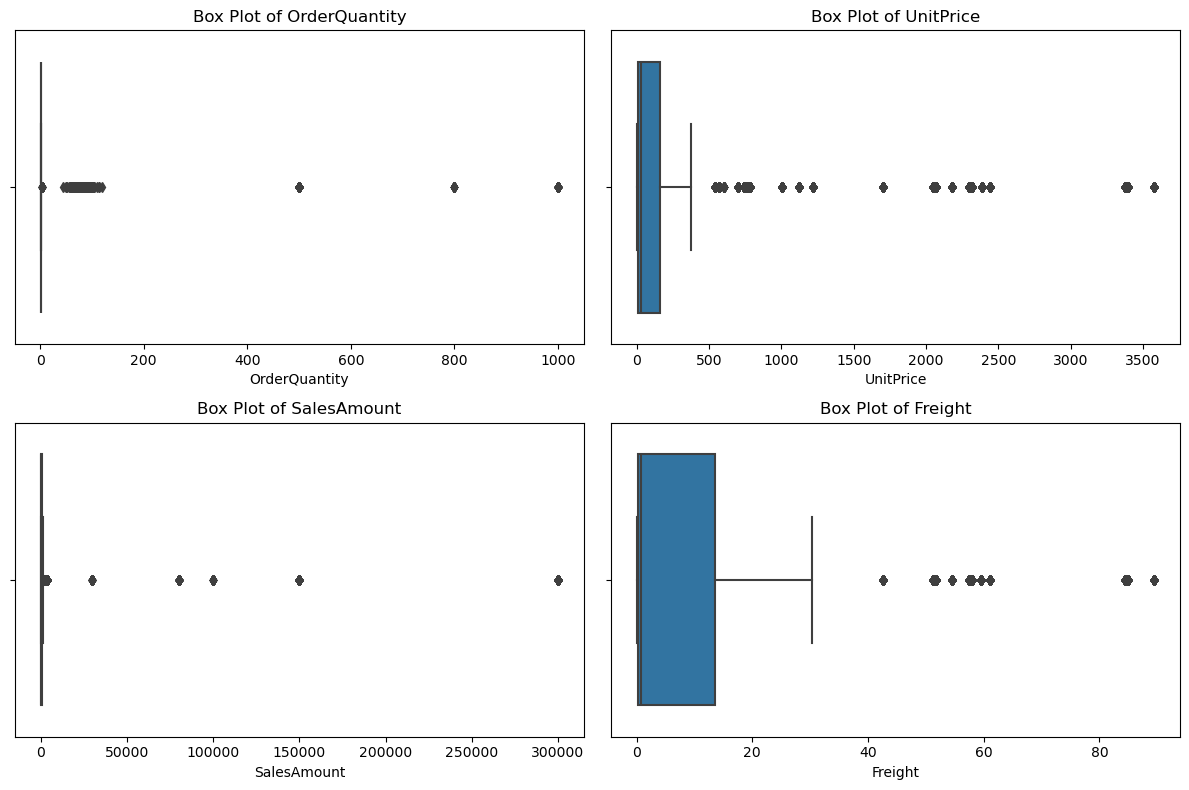

In [7]:
numeric_columns = ['OrderQuantity', 'UnitPrice', 'SalesAmount', 'Freight']

def convert_to_numeric(column):
    return col(column).cast(FloatType())

for column in numeric_columns:
    df = df.withColumn(column, convert_to_numeric(column))

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
axes = axes.flatten()

for i, column in enumerate(numeric_columns):
    sns.boxplot(x=df.select(column).toPandas()[column], ax=axes[i])
    axes[i].set_title(f'Box Plot of {column}')

plt.tight_layout()
plt.show()

In [8]:
print(df.dtypes)

[('ProductKey', 'string'), ('OrderDateKey', 'string'), ('DueDateKey', 'string'), ('ShipDateKey', 'string'), ('CustomerKey', 'string'), ('PromotionKey', 'string'), ('CurrencyKey', 'string'), ('SalesTerritoryKey', 'string'), ('SalesOrderNumber', 'string'), ('SalesOrderLineNumber', 'string'), ('RevisionNumber', 'string'), ('OrderQuantity', 'float'), ('UnitPrice', 'float'), ('ExtendedAmount', 'string'), ('UnitPriceDiscountPct', 'string'), ('DiscountAmount', 'string'), ('ProductStandardCost', 'string'), ('TotalProductCost', 'string'), ('SalesAmount', 'float'), ('TaxAmt', 'string'), ('Freight', 'float'), ('CarrierTrackingNumber', 'string'), ('CustomerPONumber', 'string'), ('OrderDate', 'string'), ('DueDate', 'string'), ('ShipDate', 'string')]


In [9]:
table_files = {
    "DimAccount": "C:\\Users\\Evgenija\\Desktop\\Proccesing Big Data\\Dataset_Final\\DataSet_final\\DimAccount.csv",
    "DimCurrency": "C:\\Users\\Evgenija\\Desktop\\Proccesing Big Data\\Dataset_Final\\DataSet_final\\DimCurrency.csv",
    "DimCustomer": "C:\\Users\\Evgenija\\Desktop\\Proccesing Big Data\\Dataset_Final\\DataSet_final\\DimCustomer.csv",
    "DimDate": "C:\\Users\\Evgenija\\Desktop\\Proccesing Big Data\\Dataset_Final\\DataSet_final\\DimDate.csv",
    "DimDepartmentGroup": "C:\\Users\\Evgenija\\Desktop\\Proccesing Big Data\\Dataset_Final\\DataSet_final\\DimDepartmentGroup.csv",
    "DimGeography": "C:\\Users\\Evgenija\\Desktop\\Proccesing Big Data\\Dataset_Final\\DataSet_final\\DimGeography.csv",
    "DimOrganization": "C:\\Users\\Evgenija\\Desktop\\Proccesing Big Data\\Dataset_Final\\DataSet_final\\DimOrganization.csv",
    "DimProduct": "C:\\Users\\Evgenija\\Desktop\\Proccesing Big Data\\Dataset_Final\\DataSet_final\\DimProduct.csv",
    "DimProductCategory": "C:\\Users\\Evgenija\\Desktop\\Proccesing Big Data\\Dataset_Final\\DataSet_final\\DimProductCategory.csv",
    "DimProductSubcategory": "C:\\Users\\Evgenija\\Desktop\\Proccesing Big Data\\Dataset_Final\\DataSet_final\\DimProductSubcategory.csv",
    "DimPromotion": "C:\\Users\\Evgenija\\Desktop\\Proccesing Big Data\\Dataset_Final\\DataSet_final\\DimPromotion.csv",
    "DimReseller": "C:\\Users\\Evgenija\\Desktop\\Proccesing Big Data\\Dataset_Final\\DataSet_final\\DimReseller.csv",
    "DimSalesReason": "C:\\Users\\Evgenija\\Desktop\\Proccesing Big Data\\Dataset_Final\\DataSet_final\\DimSalesReason.csv",
    "DimSalesTerritory": "C:\\Users\\Evgenija\\Desktop\\Proccesing Big Data\\Dataset_Final\\DataSet_final\\DimSalesTerritory.csv",
    "DimScenario": "C:\\Users\\Evgenija\\Desktop\\Proccesing Big Data\\Dataset_Final\\DataSet_final\\DimScenario.csv",
    "FactCallCenter": "C:\\Users\\Evgenija\\Desktop\\Proccesing Big Data\\Dataset_Final\\DataSet_final\\FactCallCenter.csv",
    "FactCurrencyRate": "C:\\Users\\Evgenija\\Desktop\\Proccesing Big Data\\Dataset_Final\\DataSet_final\\FactCurrencyRate.csv",
    "FactFinance": "C:\\Users\\Evgenija\\Desktop\\Proccesing Big Data\\Dataset_Final\\DataSet_final\\FactFinance.csv",
    "FactInternetSales": "C:\\Users\\Evgenija\\Desktop\\Proccesing Big Data\\Dataset_Final\\DataSet_final\\FactInternetSales.csv",
    "FactSalesTargets": "C:\\Users\\Evgenija\\Desktop\\Proccesing Big Data\\Dataset_Final\\DataSet_final\\FactSalesTargets.csv",
}

In [10]:
tables = {}

for table_name, file_path in table_files.items():
    table_df = spark.read.csv(file_path, header=True, inferSchema=True)
    tables[table_name] = table_df

In [11]:
for table_name, df in tables.items():
    df.createOrReplaceTempView(table_name)

In [12]:
tables

{'DimAccount': DataFrame[AccountKey: int, ParentAccountKey: int, AccountCodeAlternateKey: int, ParentAccountCodeAlternateKey: int, AccountDescription: string, AccountType: string, Operator: string, CustomMembers: string, ValueType: string, CustomMemberOptions: string],
 'DimCurrency': DataFrame[CurrencyKey: int, CurrencyAlternateKey: string, CurrencyName: string],
 'DimCustomer': DataFrame[CustomerKey: int, GeographyKey: int, CustomerAlternateKey: string, Title: string, FirstName: string, MiddleName: string, LastName: string, NameStyle: boolean, BirthDate: date, MaritalStatus: string, Suffix: string, Gender: string, EmailAddress: string, YearlyIncome: int, TotalChildren: int, NumberChildrenAtHome: int, EnglishEducation: string, SpanishEducation: string, FrenchEducation: string, EnglishOccupation: string, SpanishOccupation: string, FrenchOccupation: string, HouseOwnerFlag: int, NumberCarsOwned: int, AddressLine1: string, AddressLine2: string, Phone: string, DateFirstPurchase: date, Comm

In [13]:
spark.catalog.listTables()


[Table(name='DimAccount', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='DimCurrency', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='DimCustomer', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='DimDate', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='DimDepartmentGroup', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='DimGeography', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='DimOrganization', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='DimProduct', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='DimProductCategory', catalog=None, namespace=[], description=

In [14]:
def analyze_missing_values(tables):
    for table_name, df in tables.items():
        print(f"Table: {table_name}")

        missing_values = df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns])
        missing_values.show()

        total_rows = df.count()
        missing_percentage = missing_values.select([(F.col(c) / total_rows * 100).alias(c + "_percentage") 
                                                    for c in df.columns])
        missing_percentage.show()

analyze_missing_values(tables)

Table: DimAccount
+----------+----------------+-----------------------+-----------------------------+------------------+-----------+--------+-------------+---------+-------------------+
|AccountKey|ParentAccountKey|AccountCodeAlternateKey|ParentAccountCodeAlternateKey|AccountDescription|AccountType|Operator|CustomMembers|ValueType|CustomMemberOptions|
+----------+----------------+-----------------------+-----------------------------+------------------+-----------+--------+-------------+---------+-------------------+
|         0|               3|                      0|                            3|                 0|          1|       0|           98|        0|                 99|
+----------+----------------+-----------------------+-----------------------------+------------------+-----------+--------+-------------+---------+-------------------+

+---------------------+---------------------------+----------------------------------+----------------------------------------+--------------

+------------------+-------------------------------+--------------------------+-------------------------------+-------------------------------+------------------------------+---------------------------+--------------------------+---------------------------+---------------------------+---------------------------+--------------------------+----------------------------+--------------------------+-----------------------+---------------------------+------------------------+---------------------+-------------------------+-------------------+
|DateKey_percentage|FullDateAlternateKey_percentage|DayNumberOfWeek_percentage|EnglishDayNameOfWeek_percentage|SpanishDayNameOfWeek_percentage|FrenchDayNameOfWeek_percentage|DayNumberOfMonth_percentage|DayNumberOfYear_percentage|WeekNumberOfYear_percentage|EnglishMonthName_percentage|SpanishMonthName_percentage|FrenchMonthName_percentage|MonthNumberOfYear_percentage|CalendarQuarter_percentage|CalendarYear_percentage|CalendarSemester_percentage|FiscalQuar

+------------------+---------------------------+--------------------------+--------------------------+-------------------------+
|ProductCategoryKey|ProductCategoryAlternateKey|EnglishProductCategoryName|SpanishProductCategoryName|FrenchProductCategoryName|
+------------------+---------------------------+--------------------------+--------------------------+-------------------------+
|                 0|                          0|                         0|                         0|                        0|
+------------------+---------------------------+--------------------------+--------------------------+-------------------------+

+-----------------------------+--------------------------------------+-------------------------------------+-------------------------------------+------------------------------------+
|ProductCategoryKey_percentage|ProductCategoryAlternateKey_percentage|EnglishProductCategoryName_percentage|SpanishProductCategoryName_percentage|FrenchProductCategoryNam

+-----------------+--------------------------+--------------------+---------------------+-------------------+
|SalesTerritoryKey|SalesTerritoryAlternateKey|SalesTerritoryRegion|SalesTerritoryCountry|SalesTerritoryGroup|
+-----------------+--------------------------+--------------------+---------------------+-------------------+
|                0|                         0|                   0|                    0|                  0|
+-----------------+--------------------------+--------------------+---------------------+-------------------+

+----------------------------+-------------------------------------+-------------------------------+--------------------------------+------------------------------+
|SalesTerritoryKey_percentage|SalesTerritoryAlternateKey_percentage|SalesTerritoryRegion_percentage|SalesTerritoryCountry_percentage|SalesTerritoryGroup_percentage|
+----------------------------+-------------------------------------+-------------------------------+-------------------

+---------------------+-----------------------+---------------------+----------------------+----------------------+-----------------------+----------------------+----------------------------+---------------------------+-------------------------------+-------------------------+------------------------+--------------------+-------------------------+-------------------------------+-------------------------+------------------------------+---------------------------+----------------------+-----------------+------------------+--------------------------------+---------------------------+--------------------+------------------+-------------------+
|ProductKey_percentage|OrderDateKey_percentage|DueDateKey_percentage|ShipDateKey_percentage|CustomerKey_percentage|PromotionKey_percentage|CurrencyKey_percentage|SalesTerritoryKey_percentage|SalesOrderNumber_percentage|SalesOrderLineNumber_percentage|RevisionNumber_percentage|OrderQuantity_percentage|UnitPrice_percentage|ExtendedAmount_percentage|Uni

In [15]:
tables_to_keep = ['DimDate', 'DimProduct', 'DimSalesTerritory', 'DimCustomer', 'FactInternetSales', 'DimProductCategory', 'DimProductSubcategory', 'DimGeography', 'DimPromotion']

kept_tables = {}

for table_name in tables.keys():
    if table_name in tables_to_keep:
        kept_tables[table_name] = tables[table_name].persist()  
        spark.catalog.dropTempView(table_name)

spark.catalog.listTables()

[Table(name='DimAccount', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='DimCurrency', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='DimDepartmentGroup', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='DimOrganization', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='DimReseller', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='DimSalesReason', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='DimScenario', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='FactCallCenter', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='FactCurrencyRate', catalog=None, namespace=[], desc

In [16]:
for table_name, df in kept_tables.items():
    print(f"Table: {table_name}")

    missing_values = df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns])

    missing_values.show()

    total_rows = df.count()
    missing_percentage = missing_values.select([(F.col(c) / total_rows * 100).alias(c + "_percentage") for c in df.columns])
    missing_percentage.show()


Table: DimCustomer
+-----------+------------+--------------------+-----+---------+----------+--------+---------+---------+-------------+------+------+------------+------------+-------------+--------------------+----------------+----------------+---------------+-----------------+-----------------+----------------+--------------+---------------+------------+------------+-----+-----------------+---------------+
|CustomerKey|GeographyKey|CustomerAlternateKey|Title|FirstName|MiddleName|LastName|NameStyle|BirthDate|MaritalStatus|Suffix|Gender|EmailAddress|YearlyIncome|TotalChildren|NumberChildrenAtHome|EnglishEducation|SpanishEducation|FrenchEducation|EnglishOccupation|SpanishOccupation|FrenchOccupation|HouseOwnerFlag|NumberCarsOwned|AddressLine1|AddressLine2|Phone|DateFirstPurchase|CommuteDistance|
+-----------+------------+--------------------+-----+---------+----------+--------+---------+---------+-------------+------+------+------------+------------+-------------+--------------------+---

+----------+-------------------+---------------------+---------------------+-------------------+------------------+------------------+-----------------+------------+-----------------+-----+----------------+------------+---------+----+---------+------+-----------------+-----------+-----------+-----+-----+---------+------------------+---------+-------+------+
|ProductKey|ProductAlternateKey|ProductSubcategoryKey|WeightUnitMeasureCode|SizeUnitMeasureCode|EnglishProductName|SpanishProductName|FrenchProductName|StandardCost|FinishedGoodsFlag|Color|SafetyStockLevel|ReorderPoint|ListPrice|Size|SizeRange|Weight|DaysToManufacture|ProductLine|DealerPrice|Class|Style|ModelName|EnglishDescription|StartDate|EndDate|Status|
+----------+-------------------+---------------------+---------------------+-------------------+------------------+------------------+-----------------+------------+-----------------+-----+----------------+------------+---------+----+---------+------+-----------------+-----------

+-----------------------+--------------------------------+-------------------------------+-------------------------------+------------------------------+----------------------+-------------------------------+-------------------------------+------------------------------+-----------------------------------+-----------------------------------+----------------------------------+--------------------+------------------+-----------------+-----------------+
|PromotionKey_percentage|PromotionAlternateKey_percentage|EnglishPromotionName_percentage|SpanishPromotionName_percentage|FrenchPromotionName_percentage|DiscountPct_percentage|EnglishPromotionType_percentage|SpanishPromotionType_percentage|FrenchPromotionType_percentage|EnglishPromotionCategory_percentage|SpanishPromotionCategory_percentage|FrenchPromotionCategory_percentage|StartDate_percentage|EndDate_percentage|MinQty_percentage|MaxQty_percentage|
+-----------------------+--------------------------------+-------------------------------+

In [17]:
spark.catalog.listTables()

[Table(name='DimAccount', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='DimCurrency', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='DimDepartmentGroup', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='DimOrganization', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='DimReseller', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='DimSalesReason', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='DimScenario', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='FactCallCenter', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='FactCurrencyRate', catalog=None, namespace=[], desc

In [18]:
columns_to_drop_customer = ['Title', 'Suffix', 'AddressLine2', 'MiddleName',  'SpanishEducation', 'FrenchEducation', 'SpanishOccupation', 'NameStyle']
kept_tables['DimCustomer'] = kept_tables['DimCustomer'].drop(*columns_to_drop_customer)

columns_to_drop_product = ['WeightUnitMeasureCode', 'SizeUnitMeasureCode', 'EnglishProductName', 'SpanishProductName', 'FrenchProductName', 'DealerPrice', 'Status']
kept_tables['DimProduct'] = kept_tables['DimProduct'].drop(*columns_to_drop_product)

for table_name, df in kept_tables.items():
    df.createOrReplaceTempView(table_name)
    df.persist()

spark.catalog.listTables()

[Table(name='DimAccount', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='DimCurrency', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='DimCustomer', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='DimDate', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='DimDepartmentGroup', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='DimGeography', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='DimOrganization', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='DimProduct', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='DimProductCategory', catalog=None, namespace=[], description=

In [19]:
kept_tables['DimCustomer']

DataFrame[CustomerKey: int, GeographyKey: int, CustomerAlternateKey: string, FirstName: string, LastName: string, BirthDate: date, MaritalStatus: string, Gender: string, EmailAddress: string, YearlyIncome: int, TotalChildren: int, NumberChildrenAtHome: int, EnglishEducation: string, EnglishOccupation: string, FrenchOccupation: string, HouseOwnerFlag: int, NumberCarsOwned: int, AddressLine1: string, Phone: string, DateFirstPurchase: date, CommuteDistance: string]

In [20]:
def check_data_types(df):
    for col_name, col_type in df.dtypes:
        if "int" in col_type.lower():
            df = df.withColumn(col_name, col(col_name).cast(IntegerType()))
        elif "double" in col_type.lower():
            df = df.withColumn(col_name, col(col_name).cast(DoubleType()))
        elif "date" in col_type.lower():
            df = df.withColumn(col_name, col(col_name).cast(DateType()))
    return df

In [21]:
for table_name, df in kept_tables.items():
    kept_tables[table_name] = check_data_types(df)


In [22]:
for table_name, df in kept_tables.items():
    print(f"Table: {table_name}")
    df.printSchema()
    print("\n")

Table: DimCustomer
root
 |-- CustomerKey: integer (nullable = true)
 |-- GeographyKey: integer (nullable = true)
 |-- CustomerAlternateKey: string (nullable = true)
 |-- FirstName: string (nullable = true)
 |-- LastName: string (nullable = true)
 |-- BirthDate: date (nullable = true)
 |-- MaritalStatus: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- EmailAddress: string (nullable = true)
 |-- YearlyIncome: integer (nullable = true)
 |-- TotalChildren: integer (nullable = true)
 |-- NumberChildrenAtHome: integer (nullable = true)
 |-- EnglishEducation: string (nullable = true)
 |-- EnglishOccupation: string (nullable = true)
 |-- FrenchOccupation: string (nullable = true)
 |-- HouseOwnerFlag: integer (nullable = true)
 |-- NumberCarsOwned: integer (nullable = true)
 |-- AddressLine1: string (nullable = true)
 |-- Phone: string (nullable = true)
 |-- DateFirstPurchase: date (nullable = true)
 |-- CommuteDistance: string (nullable = true)



Table: DimDate
root
 |-- D

In [23]:
kept_tables['DimProduct'] = kept_tables['DimProduct'].withColumn('EndDate', to_date(col('EndDate')))
kept_tables['DimProduct'] = kept_tables['DimProduct'].withColumn('StartDate', to_date(col('StartDate')))

In [24]:
kept_tables

{'DimCustomer': DataFrame[CustomerKey: int, GeographyKey: int, CustomerAlternateKey: string, FirstName: string, LastName: string, BirthDate: date, MaritalStatus: string, Gender: string, EmailAddress: string, YearlyIncome: int, TotalChildren: int, NumberChildrenAtHome: int, EnglishEducation: string, EnglishOccupation: string, FrenchOccupation: string, HouseOwnerFlag: int, NumberCarsOwned: int, AddressLine1: string, Phone: string, DateFirstPurchase: date, CommuteDistance: string],
 'DimDate': DataFrame[DateKey: int, FullDateAlternateKey: string, DayNumberOfWeek: int, EnglishDayNameOfWeek: string, SpanishDayNameOfWeek: string, FrenchDayNameOfWeek: string, DayNumberOfMonth: int, DayNumberOfYear: int, WeekNumberOfYear: int, EnglishMonthName: string, SpanishMonthName: string, FrenchMonthName: string, MonthNumberOfYear: int, CalendarQuarter: int, CalendarYear: int, CalendarSemester: int, FiscalQuarter: int, FiscalYear: int, FiscalSemester: int, Max Year: string],
 'DimGeography': DataFrame[Ge

In [25]:
kept_tables['DimCustomer'].printSchema()


root
 |-- CustomerKey: integer (nullable = true)
 |-- GeographyKey: integer (nullable = true)
 |-- CustomerAlternateKey: string (nullable = true)
 |-- FirstName: string (nullable = true)
 |-- LastName: string (nullable = true)
 |-- BirthDate: date (nullable = true)
 |-- MaritalStatus: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- EmailAddress: string (nullable = true)
 |-- YearlyIncome: integer (nullable = true)
 |-- TotalChildren: integer (nullable = true)
 |-- NumberChildrenAtHome: integer (nullable = true)
 |-- EnglishEducation: string (nullable = true)
 |-- EnglishOccupation: string (nullable = true)
 |-- FrenchOccupation: string (nullable = true)
 |-- HouseOwnerFlag: integer (nullable = true)
 |-- NumberCarsOwned: integer (nullable = true)
 |-- AddressLine1: string (nullable = true)
 |-- Phone: string (nullable = true)
 |-- DateFirstPurchase: date (nullable = true)
 |-- CommuteDistance: string (nullable = true)



In [26]:
kept_tables['DimCustomer'] = kept_tables['DimCustomer'].withColumn('HouseOwnerFlag', col('HouseOwnerFlag') == 1)


In [27]:
kept_tables['DimCustomer'].printSchema()


root
 |-- CustomerKey: integer (nullable = true)
 |-- GeographyKey: integer (nullable = true)
 |-- CustomerAlternateKey: string (nullable = true)
 |-- FirstName: string (nullable = true)
 |-- LastName: string (nullable = true)
 |-- BirthDate: date (nullable = true)
 |-- MaritalStatus: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- EmailAddress: string (nullable = true)
 |-- YearlyIncome: integer (nullable = true)
 |-- TotalChildren: integer (nullable = true)
 |-- NumberChildrenAtHome: integer (nullable = true)
 |-- EnglishEducation: string (nullable = true)
 |-- EnglishOccupation: string (nullable = true)
 |-- FrenchOccupation: string (nullable = true)
 |-- HouseOwnerFlag: boolean (nullable = true)
 |-- NumberCarsOwned: integer (nullable = true)
 |-- AddressLine1: string (nullable = true)
 |-- Phone: string (nullable = true)
 |-- DateFirstPurchase: date (nullable = true)
 |-- CommuteDistance: string (nullable = true)



In [28]:
spark.catalog.listTables()

[Table(name='DimAccount', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='DimCurrency', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='DimCustomer', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='DimDate', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='DimDepartmentGroup', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='DimGeography', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='DimOrganization', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='DimProduct', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='DimProductCategory', catalog=None, namespace=[], description=

In [29]:
kept_tables

{'DimCustomer': DataFrame[CustomerKey: int, GeographyKey: int, CustomerAlternateKey: string, FirstName: string, LastName: string, BirthDate: date, MaritalStatus: string, Gender: string, EmailAddress: string, YearlyIncome: int, TotalChildren: int, NumberChildrenAtHome: int, EnglishEducation: string, EnglishOccupation: string, FrenchOccupation: string, HouseOwnerFlag: boolean, NumberCarsOwned: int, AddressLine1: string, Phone: string, DateFirstPurchase: date, CommuteDistance: string],
 'DimDate': DataFrame[DateKey: int, FullDateAlternateKey: string, DayNumberOfWeek: int, EnglishDayNameOfWeek: string, SpanishDayNameOfWeek: string, FrenchDayNameOfWeek: string, DayNumberOfMonth: int, DayNumberOfYear: int, WeekNumberOfYear: int, EnglishMonthName: string, SpanishMonthName: string, FrenchMonthName: string, MonthNumberOfYear: int, CalendarQuarter: int, CalendarYear: int, CalendarSemester: int, FiscalQuarter: int, FiscalYear: int, FiscalSemester: int, Max Year: string],
 'DimGeography': DataFram

In [30]:

dim_customer_pd = kept_tables['DimCustomer'].toPandas()

print(dim_customer_pd)

       CustomerKey  GeographyKey CustomerAlternateKey  FirstName LastName  \
0            11000            26           AW00011000        Jon     Yang   
1            11001            37           AW00011001     Eugene    Huang   
2            11002            31           AW00011002      Ruben   Torres   
3            11003            11           AW00011003    Christy      Zhu   
4            11004            19           AW00011004  Elizabeth  Johnson   
...            ...           ...                  ...        ...      ...   
18479        29479           209           AW00029479      Tommy     Tang   
18480        29480           248           AW00029480       Nina     Raji   
18481        29481           120           AW00029481       Ivan     Suri   
18482        29482           179           AW00029482    Clayton    Zhang   
18483        29483           217           AW00029483      J�sus  Navarro   

        BirthDate MaritalStatus Gender                    EmailAddress  \
0

In [31]:
commute_values_df = (
    kept_tables['DimCustomer']
    .select('CommuteDistance')
    .distinct()
    .withColumn('CommuteDistanceKey', F.monotonically_increasing_id())
)

commute_values_df.createOrReplaceTempView('CommuteDistanceLookup')

kept_tables['CommuteDistanceLookup'] = commute_values_df

kept_tables['DimCustomer'] = (
    kept_tables['DimCustomer']
    .join(commute_values_df, 'CommuteDistance')
    .persist()
)

mapping_df = commute_values_df.select("CommuteDistance", "CommuteDistanceKey")

df_preprocessed = kept_tables['DimCustomer'].join(mapping_df, on="CommuteDistance", how="left_outer")

In [32]:

commute_values_df.createOrReplaceTempView('CommuteDistanceLookup')


In [33]:
spark.catalog.listTables()

[Table(name='CommuteDistanceLookup', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='DimAccount', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='DimCurrency', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='DimCustomer', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='DimDate', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='DimDepartmentGroup', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='DimGeography', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='DimOrganization', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='DimProduct', catalog=None, namespace=[], descripti

In [34]:
kept_tables['CommuteDistanceLookup'] = commute_values_df

In [35]:
kept_tables['DimCustomer'] = (
    kept_tables['DimCustomer']
    .join(commute_values_df, 'CommuteDistance')
    .persist()
)

In [36]:

dim_customer_pd = kept_tables['CommuteDistanceLookup'].toPandas()

print(dim_customer_pd)

  CommuteDistance  CommuteDistanceKey
0       0-1 Miles                   0
1       10+ Miles                   1
2       2-5 Miles                   2
3      5-10 Miles                   3
4       1-2 Miles                   4


In [37]:

dim_customer_pd = kept_tables['DimCustomer'].toPandas()

print(dim_customer_pd)

      CommuteDistance  CustomerKey  GeographyKey CustomerAlternateKey  \
0           1-2 Miles        11000            26           AW00011000   
1           0-1 Miles        11001            37           AW00011001   
2           2-5 Miles        11002            31           AW00011002   
3          5-10 Miles        11003            11           AW00011003   
4           1-2 Miles        11004            19           AW00011004   
...               ...          ...           ...                  ...   
18479       0-1 Miles        29479           209           AW00029479   
18480       0-1 Miles        29480           248           AW00029480   
18481       0-1 Miles        29481           120           AW00029481   
18482       0-1 Miles        29482           179           AW00029482   
18483       0-1 Miles        29483           217           AW00029483   

       FirstName LastName   BirthDate MaritalStatus Gender  \
0            Jon     Yang  1966-04-08             M      M   

In [38]:
df_dim_customer = kept_tables['DimCustomer']
df_commute_distance_lookup = kept_tables['CommuteDistanceLookup']



In [39]:
mapping_df = df_commute_distance_lookup.select("CommuteDistance", "CommuteDistanceKey")



In [40]:
df_preprocessed = df_dim_customer.join(mapping_df, on="CommuteDistance", how="left_outer")

df_preprocessed.show()


+---------------+-----------+------------+--------------------+---------+--------+----------+-------------+------+--------------------+------------+-------------+--------------------+----------------+-----------------+----------------+--------------+---------------+--------------------+-------------------+-----------------+------------------+------------------+------------------+
|CommuteDistance|CustomerKey|GeographyKey|CustomerAlternateKey|FirstName|LastName| BirthDate|MaritalStatus|Gender|        EmailAddress|YearlyIncome|TotalChildren|NumberChildrenAtHome|EnglishEducation|EnglishOccupation|FrenchOccupation|HouseOwnerFlag|NumberCarsOwned|        AddressLine1|              Phone|DateFirstPurchase|CommuteDistanceKey|CommuteDistanceKey|CommuteDistanceKey|
+---------------+-----------+------------+--------------------+---------+--------+----------+-------------+------+--------------------+------------+-------------+--------------------+----------------+-----------------+----------------

In [41]:

df_preprocessed = df_preprocessed.drop("CommuteDistance")

df_preprocessed.show()

+-----------+------------+--------------------+---------+--------+----------+-------------+------+--------------------+------------+-------------+--------------------+----------------+-----------------+----------------+--------------+---------------+--------------------+-------------------+-----------------+------------------+------------------+------------------+
|CustomerKey|GeographyKey|CustomerAlternateKey|FirstName|LastName| BirthDate|MaritalStatus|Gender|        EmailAddress|YearlyIncome|TotalChildren|NumberChildrenAtHome|EnglishEducation|EnglishOccupation|FrenchOccupation|HouseOwnerFlag|NumberCarsOwned|        AddressLine1|              Phone|DateFirstPurchase|CommuteDistanceKey|CommuteDistanceKey|CommuteDistanceKey|
+-----------+------------+--------------------+---------+--------+----------+-------------+------+--------------------+------------+-------------+--------------------+----------------+-----------------+----------------+--------------+---------------+----------------

In [42]:
kept_tables['DimCustomer'] = df_preprocessed

In [43]:
dim_customer_pd = kept_tables['DimCustomer'].toPandas()

print(dim_customer_pd)

       CustomerKey  GeographyKey CustomerAlternateKey  FirstName LastName  \
0            11000            26           AW00011000        Jon     Yang   
1            11001            37           AW00011001     Eugene    Huang   
2            11002            31           AW00011002      Ruben   Torres   
3            11003            11           AW00011003    Christy      Zhu   
4            11004            19           AW00011004  Elizabeth  Johnson   
...            ...           ...                  ...        ...      ...   
18479        29479           209           AW00029479      Tommy     Tang   
18480        29480           248           AW00029480       Nina     Raji   
18481        29481           120           AW00029481       Ivan     Suri   
18482        29482           179           AW00029482    Clayton    Zhang   
18483        29483           217           AW00029483      J�sus  Navarro   

        BirthDate MaritalStatus Gender                    EmailAddress  \
0

In [44]:
tables = spark.catalog.listTables()

for table in tables:
    view_name = table.name
    spark.catalog.dropTempView(view_name)

In [45]:
for table_name, df in kept_tables.items():
    spark.catalog.dropTempView(table_name)
    df.createOrReplaceTempView(table_name)

In [46]:
spark.catalog.listTables()

[Table(name='CommuteDistanceLookup', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='DimCustomer', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='DimDate', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='DimGeography', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='DimProduct', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='DimProductCategory', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='DimProductSubcategory', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='DimPromotion', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='DimSalesTerritory', catalog=None, namespace

In [47]:
# output_folder = "C:\\Users\\Evgenija\\Desktop\\Proccesing Big Data\\Dataset_Final\\Dataset_Preprocessed"

# for table_name, df in kept_tables.items():
#     for column in df.schema:
#         if 'timestamp' in str(column.dataType).lower():
#             df = df.withColumn(column.name, col(column.name).cast('string'))

#     pandas_df = df.toPandas()

#     os.makedirs(output_folder, exist_ok=True)

#     output_file_path = os.path.join(output_folder, f"{table_name}.csv")
#     pandas_df.to_csv(output_file_path, index=False)


In [48]:
df_preprocessed = kept_tables

In [49]:
df_preprocessed

{'DimCustomer': DataFrame[CustomerKey: int, GeographyKey: int, CustomerAlternateKey: string, FirstName: string, LastName: string, BirthDate: date, MaritalStatus: string, Gender: string, EmailAddress: string, YearlyIncome: int, TotalChildren: int, NumberChildrenAtHome: int, EnglishEducation: string, EnglishOccupation: string, FrenchOccupation: string, HouseOwnerFlag: boolean, NumberCarsOwned: int, AddressLine1: string, Phone: string, DateFirstPurchase: date, CommuteDistanceKey: bigint, CommuteDistanceKey: bigint, CommuteDistanceKey: bigint],
 'DimDate': DataFrame[DateKey: int, FullDateAlternateKey: string, DayNumberOfWeek: int, EnglishDayNameOfWeek: string, SpanishDayNameOfWeek: string, FrenchDayNameOfWeek: string, DayNumberOfMonth: int, DayNumberOfYear: int, WeekNumberOfYear: int, EnglishMonthName: string, SpanishMonthName: string, FrenchMonthName: string, MonthNumberOfYear: int, CalendarQuarter: int, CalendarYear: int, CalendarSemester: int, FiscalQuarter: int, FiscalYear: int, Fiscal

In [50]:
sales_df = kept_tables['FactInternetSales']

relevant_columns = ['OrderDate', 'SalesAmount', 'TaxAmt', 'Freight']

sales_subset_df = sales_df[relevant_columns]

In [51]:
sales_subset_df.select('OrderDate').distinct().show()


+-------------------+
|          OrderDate|
+-------------------+
|2011-06-03 00:00:00|
|2011-06-08 00:00:00|
|2011-10-08 00:00:00|
|2012-08-01 00:00:00|
|2013-03-31 00:00:00|
|2011-02-14 00:00:00|
|2012-08-18 00:00:00|
|2012-10-16 00:00:00|
|2012-12-05 00:00:00|
|2011-02-10 00:00:00|
|2011-06-26 00:00:00|
|2011-07-09 00:00:00|
|2012-08-07 00:00:00|
|2012-11-09 00:00:00|
|2011-05-30 00:00:00|
|2011-06-13 00:00:00|
|2012-01-23 00:00:00|
|2012-04-02 00:00:00|
|2012-09-11 00:00:00|
|2012-10-30 00:00:00|
+-------------------+
only showing top 20 rows



In [52]:
sales_subset_df = sales_subset_df.withColumn('OrderDate', to_date(col('OrderDate')))

sales_subset_df.show()

+----------+-----------+--------+-------+
| OrderDate|SalesAmount|  TaxAmt|Freight|
+----------+-----------+--------+-------+
|2010-12-29|    3578.27|286.2616|89.4568|
|2010-12-29|    3399.99|271.9992|84.9998|
|2010-12-29|    3399.99|271.9992|84.9998|
|2010-12-29|   699.0982| 55.9279|17.4775|
|2010-12-29|    3399.99|271.9992|84.9998|
|2010-12-30|    3578.27|286.2616|89.4568|
|2010-12-30|    3578.27|286.2616|89.4568|
|2010-12-30|    3374.99|269.9992|84.3748|
|2010-12-30|    3399.99|271.9992|84.9998|
|2010-12-31|    3578.27|286.2616|89.4568|
|2010-12-31|    3578.27|286.2616|89.4568|
|2010-12-31|   699.0982| 55.9279|17.4775|
|2010-12-31|    3578.27|286.2616|89.4568|
|2010-12-31|    3578.27|286.2616|89.4568|
|2011-01-01|    3578.27|286.2616|89.4568|
|2011-01-01|    3578.27|286.2616|89.4568|
|2011-01-02|    3578.27|286.2616|89.4568|
|2011-01-02|    3578.27|286.2616|89.4568|
|2011-01-02|    3578.27|286.2616|89.4568|
|2011-01-02|    3578.27|286.2616|89.4568|
+----------+-----------+--------+-

In [53]:
sales_time_df = sales_subset_df.toPandas()

C:\Users\Evgenija\anaconda3\envs\ProccesingBigData\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Evgenija\anaconda3\envs\ProccesingBigData\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


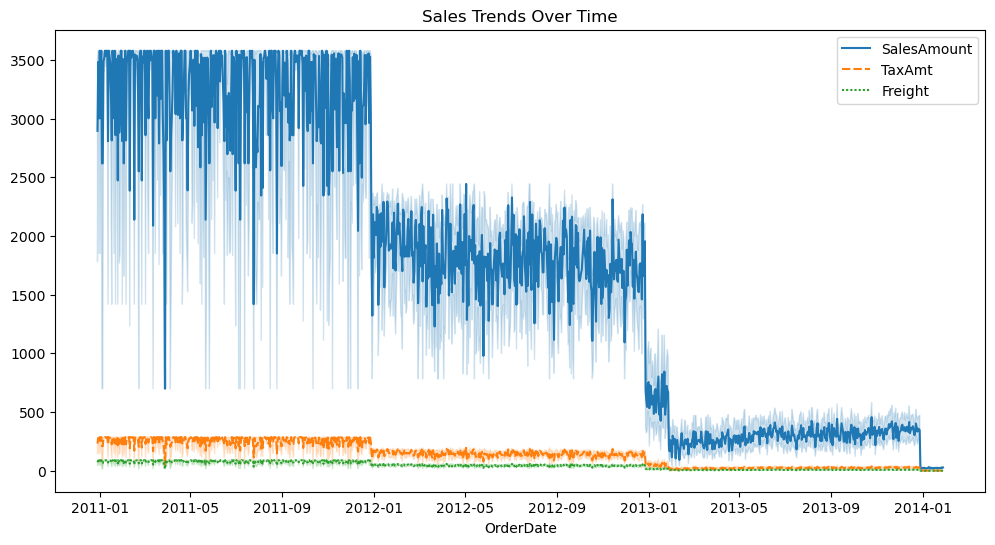

In [54]:
sales_time_df.set_index('OrderDate', inplace=True)

plt.figure(figsize=(12, 6))
sns.lineplot(data=sales_time_df)
plt.title('Sales Trends Over Time')
plt.show()

In [55]:
df_preprocessed['DimProduct'].createOrReplaceTempView("dim_product")
df_preprocessed['FactInternetSales'].createOrReplaceTempView("fact_sales")
df_preprocessed['DimProductSubcategory'].createOrReplaceTempView("dim_product_subcategory")

query = """
    SELECT
        p.ProductKey,
        p.ProductAlternateKey,
        dps.EnglishProductSubcategoryName AS ProductSubcategory,
        s.OrderDate,
        s.SalesAmount
    FROM
        dim_product p
    JOIN
        fact_sales s
    ON
        p.ProductKey = s.ProductKey
    JOIN
        dim_product_subcategory dps
    ON
        p.ProductSubcategoryKey = dps.ProductSubcategoryKey
    ORDER BY
        s.SalesAmount DESC
"""

top_selling_df = spark.sql(query)

top_selling_df.show()

top_categories_df = top_selling_df.groupBy("ProductSubcategory").agg({"SalesAmount": "sum"}).orderBy(desc("sum(SalesAmount)"))

top_categories_df.show()

+----------+-------------------+------------------+-------------------+-----------+
|ProductKey|ProductAlternateKey|ProductSubcategory|          OrderDate|SalesAmount|
+----------+-------------------+------------------+-------------------+-----------+
|       311|         BK-R93R-44|        Road Bikes|2011-01-03 00:00:00|    3578.27|
|       312|         BK-R93R-48|        Road Bikes|2011-01-08 00:00:00|    3578.27|
|       312|         BK-R93R-48|        Road Bikes|2011-01-03 00:00:00|    3578.27|
|       311|         BK-R93R-44|        Road Bikes|2011-01-03 00:00:00|    3578.27|
|       310|         BK-R93R-62|        Road Bikes|2011-01-03 00:00:00|    3578.27|
|       311|         BK-R93R-44|        Road Bikes|2010-12-30 00:00:00|    3578.27|
|       312|         BK-R93R-48|        Road Bikes|2011-01-04 00:00:00|    3578.27|
|       312|         BK-R93R-48|        Road Bikes|2010-12-31 00:00:00|    3578.27|
|       311|         BK-R93R-44|        Road Bikes|2011-01-04 00:00:00|    3

In [56]:
df_preprocessed

{'DimCustomer': DataFrame[CustomerKey: int, GeographyKey: int, CustomerAlternateKey: string, FirstName: string, LastName: string, BirthDate: date, MaritalStatus: string, Gender: string, EmailAddress: string, YearlyIncome: int, TotalChildren: int, NumberChildrenAtHome: int, EnglishEducation: string, EnglishOccupation: string, FrenchOccupation: string, HouseOwnerFlag: boolean, NumberCarsOwned: int, AddressLine1: string, Phone: string, DateFirstPurchase: date, CommuteDistanceKey: bigint, CommuteDistanceKey: bigint, CommuteDistanceKey: bigint],
 'DimDate': DataFrame[DateKey: int, FullDateAlternateKey: string, DayNumberOfWeek: int, EnglishDayNameOfWeek: string, SpanishDayNameOfWeek: string, FrenchDayNameOfWeek: string, DayNumberOfMonth: int, DayNumberOfYear: int, WeekNumberOfYear: int, EnglishMonthName: string, SpanishMonthName: string, FrenchMonthName: string, MonthNumberOfYear: int, CalendarQuarter: int, CalendarYear: int, CalendarSemester: int, FiscalQuarter: int, FiscalYear: int, Fiscal

In [57]:
df_preprocessed['DimCustomer'].createOrReplaceTempView("dim_customer")
df_preprocessed['FactInternetSales'].createOrReplaceTempView("fact_sales")

query = """
    SELECT
        c.CustomerKey,
        c.FirstName,
        c.LastName,
        c.EmailAddress,
        SUM(s.SalesAmount) AS TotalSales
    FROM
        dim_customer c
    JOIN
        fact_sales s
    ON
        c.CustomerKey = s.CustomerKey
    GROUP BY
        c.CustomerKey, c.FirstName, c.LastName, c.EmailAddress
    ORDER BY
        TotalSales DESC
"""

customer_segment_df = spark.sql(query)

customer_segment_df.show()

+-----------+---------+---------+--------------------+------------------+
|CustomerKey|FirstName| LastName|        EmailAddress|        TotalSales|
+-----------+---------+---------+--------------------+------------------+
|      12301|  Nichole|     Nara|nichole16@adventu...|          13295.38|
|      12132|  Kaitlyn|Henderson|kaitlyn72@adventu...|13294.269999999999|
|      12308| Margaret|       He|margaret25@advent...|13269.269999999999|
|      12131|  Randall|Dominguez|randall14@adventu...|          13265.99|
|      12300|  Adriana| Gonzalez|adriana19@adventu...|13242.699999999999|
|      12321|     Rosa|       Hu|rosa20@adventure-...|13215.649999999998|
|      12124|   Brandi|     Gill|brandi13@adventur...|          13195.64|
|      12307|     Brad|      She|brad1@adventure-w...|13173.189999999999|
|      12296|Francisco|     Sara|francisco11@adven...|13164.639999999998|
|      11433|  Maurice|     Shan|maurice11@adventu...|        12909.6682|
|      11439|    Janet|    Munoz|janet

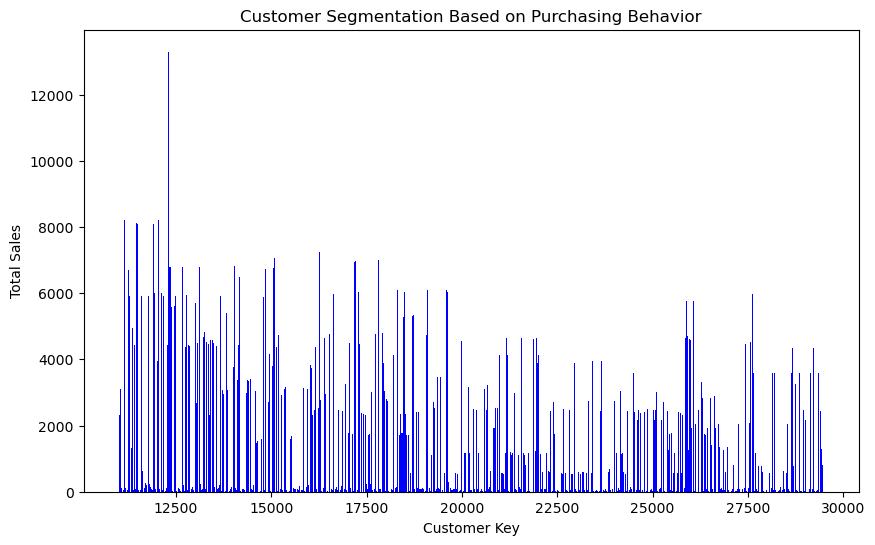

In [58]:
customer_segment_pd = customer_segment_df.toPandas()

plt.figure(figsize=(10, 6))
plt.bar(customer_segment_pd['CustomerKey'], customer_segment_pd['TotalSales'], color='blue')
plt.xlabel('Customer Key')
plt.ylabel('Total Sales')
plt.title('Customer Segmentation Based on Purchasing Behavior')
plt.show()

In [59]:
query = """
    SELECT
        g.City,
        g.StateProvinceName,
        g.CountryRegionCode,
        SUM(s.SalesAmount) AS TotalSales
    FROM
        DimGeography g
    JOIN
        FactInternetSales s
    ON
        g.GeographyKey = s.SalesTerritoryKey
    GROUP BY
        g.City, g.StateProvinceName, g.CountryRegionCode
    ORDER BY
        TotalSales DESC
"""

geographical_patterns_df = spark.sql(query)

geographical_patterns_df.show()

+-------------+-----------------+-----------------+------------------+
|         City|StateProvinceName|CountryRegionCode|        TotalSales|
+-------------+-----------------+-----------------+------------------+
|Milsons Point|  New South Wales|               AU| 9061000.584400563|
|     Goulburn|  New South Wales|               AU| 5718150.812200519|
|   Alexandria|  New South Wales|               AU|3649866.5511999447|
|    Newcastle|  New South Wales|               AU|3391712.2108999686|
|   Matraville|  New South Wales|               AU| 2894312.338199975|
|      Malabar|  New South Wales|               AU|2644017.7142999778|
| Lavender Bay|  New South Wales|               AU|1977844.8620999614|
|    Lane Cove|  New South Wales|               AU|12238.849599999994|
|Coffs Harbour|  New South Wales|               AU|6532.4681999999975|
| Darlinghurst|  New South Wales|               AU| 3000.829599999999|
+-------------+-----------------+-----------------+------------------+



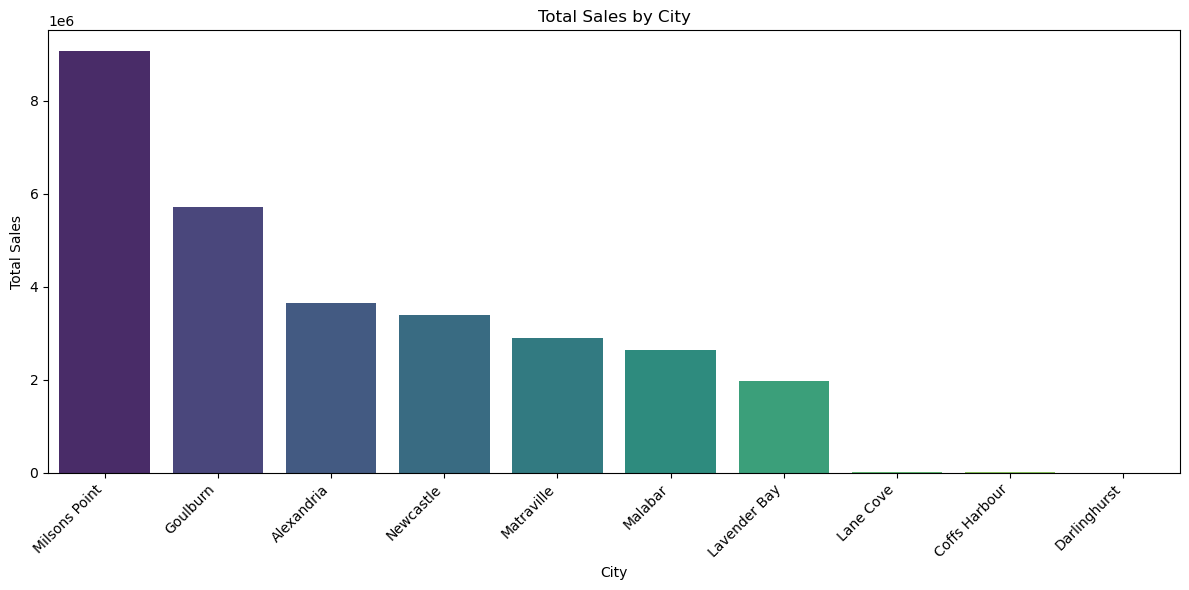

In [60]:
geographical_patterns_pd = geographical_patterns_df.toPandas()

plt.figure(figsize=(12, 6))
sns.barplot(x='City', y='TotalSales', data=geographical_patterns_pd, palette='viridis')
plt.xlabel('City')
plt.ylabel('Total Sales')
plt.title('Total Sales by City')
plt.xticks(rotation=45, ha='right') 
plt.tight_layout()

plt.show()

In [61]:
joined_df = df_preprocessed['FactInternetSales'].alias("fs").join(
    df_preprocessed['DimCustomer'].alias("dc"),
    df_preprocessed['FactInternetSales']["CustomerKey"] == df_preprocessed['DimCustomer']["CustomerKey"]
)

loyalty_df = joined_df.groupBy("fs.CustomerKey", "dc.FirstName", "dc.LastName").agg(
    F.count("fs.OrderDate").alias("PurchaseFrequency")
)

loyal_customers_df = loyalty_df.filter(loyalty_df["PurchaseFrequency"] > 1)
loyal_customers_df = loyal_customers_df.orderBy("PurchaseFrequency", ascending=False)


loyal_customers_df.show()

+-----------+---------+---------+-----------------+
|CustomerKey|FirstName| LastName|PurchaseFrequency|
+-----------+---------+---------+-----------------+
|      11185|   Ashley|Henderson|               68|
|      11300| Fernando|   Barnes|               67|
|      11277|  Charles|  Jackson|               65|
|      11262| Jennifer|  Simmons|               63|
|      11287|    Henry|   Garcia|               62|
|      11176|    Mason|  Roberts|               60|
|      11091|   Dalton|    Perez|               59|
|      11331| Samantha|  Jenkins|               58|
|      11566|    April|     Shan|               58|
|      11330|     Ryan| Thompson|               57|
|      11276|    Nancy|  Chapman|               57|
|      11223|   Hailey|Patterson|               56|
|      11200|    Jason|  Griffin|               55|
|      11711|   Daniel|    Davis|               55|
|      11502|    Jared| Peterson|               43|
|      11505|  Jasmine|   Powell|               36|
|      11519

In [62]:
df_preprocessed['DimProduct'].count()

606

In [63]:
df_dim_product = df_preprocessed['DimProduct']

df_dim_product = df_preprocessed['DimProduct'].withColumn("row_id", monotonically_increasing_id())

df_dim_product = df_dim_product.filter(df_dim_product.row_id > 237).drop("row_id")


In [64]:
df_dim_product.count()

368

In [65]:
df_preprocessed['DimProduct'] = df_dim_product

In [66]:
df_preprocessed['DimProduct'].count()

368

In [67]:
df_dim_product = df_preprocessed['DimProduct']

color_indexer = StringIndexer(inputCol='Color', outputCol='ColorIndex', handleInvalid='skip')

size_indexer = StringIndexer(inputCol='Size', outputCol='SizeIndex', handleInvalid='skip')

df_dim_product = color_indexer.fit(df_dim_product).transform(df_dim_product)
df_dim_product = size_indexer.fit(df_dim_product).transform(df_dim_product)

df_dim_product = df_dim_product.dropna(subset=['ColorIndex', 'SizeIndex'])

df_joined = df_preprocessed['FactInternetSales'].join(df_dim_product, on='ProductKey')

selected_features = ['DiscountAmount', 'StandardCost', 'ColorIndex', 'SizeIndex', 'Weight', 'DaysToManufacture']
target_variable = 'SalesAmount'

df_selected = df_joined.select(selected_features + [target_variable])

df_pandas = df_selected.toPandas()

In [68]:
X = df_pandas[selected_features]
y = df_pandas[target_variable]

imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r_squared}')


Mean Squared Error: 6660.456921072696
R-squared: 0.994711162589251


In [69]:
feature_importance = model.coef_

feature_importance_dict = dict(zip(selected_features, feature_importance))

print("Feature Importances:")
for feature, importance in feature_importance_dict.items():
    print(f"{feature}: {importance}")

Feature Importances:
DiscountAmount: 0.0
StandardCost: 1.743548764248381
ColorIndex: -8.499776553181537
SizeIndex: -7.993093532937081
Weight: 19.967996966485156
DaysToManufacture: -35.27262663813413


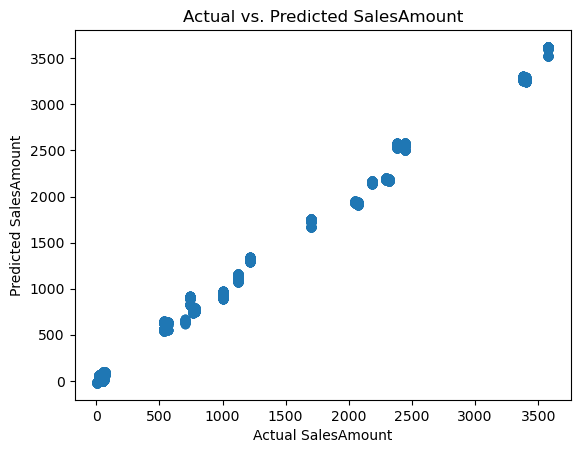

In [70]:
plt.scatter(y_test, y_pred)
plt.xlabel("Actual SalesAmount")
plt.ylabel("Predicted SalesAmount")
plt.title("Actual vs. Predicted SalesAmount")
plt.show()

In [71]:
fact_sales_df = df_preprocessed['FactInternetSales']

selected_columns = ['OrderQuantity', 'UnitPrice', 'ExtendedAmount', 'UnitPriceDiscountPct', 'DiscountAmount', 'ProductStandardCost', 'TotalProductCost', 'SalesAmount', 'TaxAmt', 'Freight']
selected_data = df_preprocessed['FactInternetSales'].select(selected_columns)

In [72]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(selected_data.toPandas())

In [73]:
k = 4

kmeans = KMeans(n_clusters=k, random_state=42)
df_preprocessed['Cluster'] = kmeans.fit_predict(scaled_data)

C:\Users\Evgenija\anaconda3\envs\ProccesingBigData\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [74]:
df_preprocessed['Cluster']


array([2, 2, 2, ..., 0, 0, 0])

In [75]:
print("Inertia:", kmeans.inertia_)


Inertia: 6639.38102766242


In [76]:
silhouette_avg = silhouette_score(scaled_data, kmeans.labels_)
print("Silhouette Score:", silhouette_avg)

Silhouette Score: 0.9119315478442598


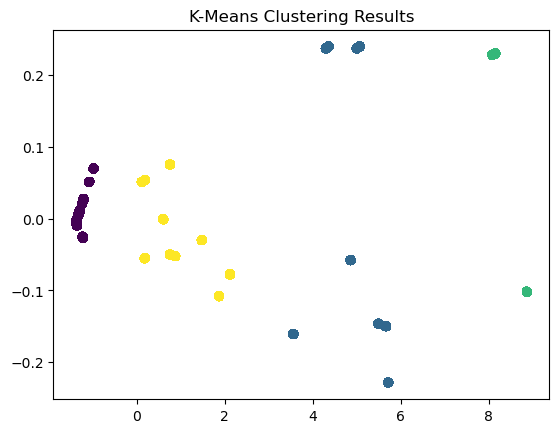

In [77]:
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_data)

plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=kmeans.labels_, cmap='viridis')
plt.title("K-Means Clustering Results")
plt.show()

In [78]:
dim_promotion_df = df_preprocessed['DimPromotion']
fact_sales_df = df_preprocessed['FactInternetSales']

In [79]:

dim_promotion_df.createOrReplaceTempView("dim_promotion")
fact_sales_df.createOrReplaceTempView("fact_sales")

query = """
    SELECT dp.*, fis.*
    FROM dim_promotion dp
    INNER JOIN fact_sales fis ON dp.PromotionKey = fis.PromotionKey
"""

merged_df = spark.sql(query)


In [80]:
dim_promotion_df = df_preprocessed['DimPromotion']
fact_sales_df = df_preprocessed['FactInternetSales']

dim_promotion_df.createOrReplaceTempView("dim_promotion")
fact_sales_df.createOrReplaceTempView("fact_sales")

query = """
    SELECT dp.PromotionKey, dp.DiscountPct, dp.MinQty, dp.MaxQty, fis.SalesAmount, fis.TaxAmt, fis.Freight
    FROM dim_promotion dp
    INNER JOIN fact_sales fis ON dp.PromotionKey = fis.PromotionKey
"""

merged_df_spark = spark.sql(query)

merged_df = merged_df_spark.toPandas()

merged_df = merged_df.dropna()

selected_columns = ['DiscountPct', 'MinQty', 'MaxQty', 'SalesAmount', 'TaxAmt', 'Freight']
selected_data = merged_df[selected_columns]

scaler = StandardScaler()
scaled_data = scaler.fit_transform(selected_data)

k = 3 

kmeans = KMeans(n_clusters=k, random_state=42)
merged_df['Cluster'] = kmeans.fit_predict(scaled_data)

C:\Users\Evgenija\anaconda3\envs\ProccesingBigData\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Evgenija\anaconda3\envs\ProccesingBigData\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


In [81]:
print("Inertia:", kmeans.inertia_)


Inertia: 101.29622040618719


In [82]:
silhouette_avg = silhouette_score(scaled_data, kmeans.labels_)
print("Silhouette Score:", silhouette_avg)

Silhouette Score: 0.9001022127822911


In [83]:
sample_silhouette_values = silhouette_samples(scaled_data, kmeans.labels_)
sample_silhouette_values

array([0.81147316, 0.89769982, 0.89769982, ..., 0.92907356, 0.92907356,
       0.99330727])

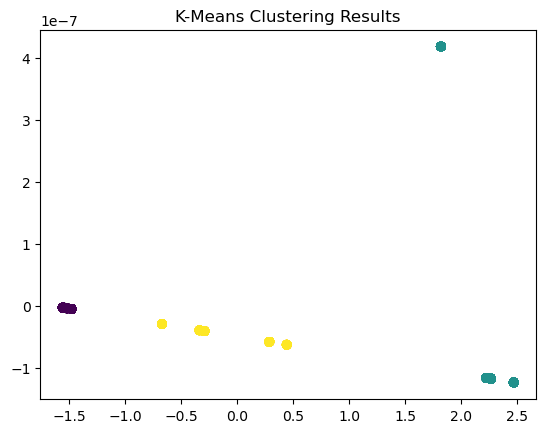

In [84]:
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_data)

plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=kmeans.labels_, cmap='viridis')
plt.title("K-Means Clustering Results")
plt.show()

In [85]:
cluster_centers = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=selected_columns)
cluster_centers['Cluster'] = range(1, k+1)

print("Cluster Centers:")
print(cluster_centers)

merged_df['Cluster'] = kmeans.labels_

for cluster_num in range(k):
    cluster_data = merged_df[merged_df['Cluster'] == cluster_num]
    print(f"\nCluster {cluster_num + 1} Details:")
    print(cluster_data[selected_columns].describe())

Cluster Centers:
   DiscountPct  MinQty  MaxQty  SalesAmount      TaxAmt    Freight  Cluster
0         0.02    11.0    14.0     7.827027    0.626162   0.195726        1
1         0.02    11.0    14.0  2278.558504  182.284692  56.964011        2
2         0.02    11.0    14.0   830.393288   66.431463  20.759882        3

Cluster 1 Details:
        DiscountPct  MinQty  MaxQty  SalesAmount       TaxAmt      Freight
count  1.056000e+03  1056.0  1056.0  1056.000000  1056.000000  1056.000000
mean   2.000000e-02    11.0    14.0     7.827027     0.626162     0.195726
std    3.436380e-16     0.0     0.0    12.993218     1.039457     0.324830
min    2.000000e-02    11.0    14.0     2.290000     0.183200     0.057300
25%    2.000000e-02    11.0    14.0     2.290000     0.183200     0.057300
50%    2.000000e-02    11.0    14.0     2.290000     0.183200     0.057300
75%    2.000000e-02    11.0    14.0     2.290000     0.183200     0.057300
max    2.000000e-02    11.0    14.0    49.990000     3.9992

In [86]:
df_preprocessed

{'DimCustomer': DataFrame[CustomerKey: int, GeographyKey: int, CustomerAlternateKey: string, FirstName: string, LastName: string, BirthDate: date, MaritalStatus: string, Gender: string, EmailAddress: string, YearlyIncome: int, TotalChildren: int, NumberChildrenAtHome: int, EnglishEducation: string, EnglishOccupation: string, FrenchOccupation: string, HouseOwnerFlag: boolean, NumberCarsOwned: int, AddressLine1: string, Phone: string, DateFirstPurchase: date, CommuteDistanceKey: bigint, CommuteDistanceKey: bigint, CommuteDistanceKey: bigint],
 'DimDate': DataFrame[DateKey: int, FullDateAlternateKey: string, DayNumberOfWeek: int, EnglishDayNameOfWeek: string, SpanishDayNameOfWeek: string, FrenchDayNameOfWeek: string, DayNumberOfMonth: int, DayNumberOfYear: int, WeekNumberOfYear: int, EnglishMonthName: string, SpanishMonthName: string, FrenchMonthName: string, MonthNumberOfYear: int, CalendarQuarter: int, CalendarYear: int, CalendarSemester: int, FiscalQuarter: int, FiscalYear: int, Fiscal

In [87]:
df_dim_customer = df_preprocessed['DimCustomer']

marital_status = StringIndexer(inputCol='MaritalStatus', outputCol='MaritalStatusIndex', handleInvalid='skip')

gender_indexer = StringIndexer(inputCol='Gender', outputCol='GenderIndex', handleInvalid='skip')

df_dim_customer = marital_status.fit(df_dim_customer).transform(df_dim_customer)
df_dim_customer = gender_indexer.fit(df_dim_customer).transform(df_dim_customer)

df_dim_customer = df_dim_customer.dropna(subset=['MaritalStatusIndex', 'GenderIndex'])
df_preprocessed['DimCustomer'] = df_dim_customer

df_dim_product = df_preprocessed['DimProduct']

color_indexer = StringIndexer(inputCol='Color', outputCol='ColorIndex', handleInvalid='skip')


df_dim_product = color_indexer.fit(df_dim_product).transform(df_dim_product)

df_dim_product = df_dim_product.dropna(subset=['ColorIndex'])
df_preprocessed['DimProduct'] = df_dim_product


In [88]:
features = [ 'SalesAmount', 'MaritalStatusIndex', 'GenderIndex', 'YearlyIncome', 'TotalChildren', 'NumberChildrenAtHome', 'NumberCarsOwned',  'ColorIndex']
features_fis = ['OrderQuantity', 'UnitPrice', 'TaxAmt', 'Freight', 'SalesAmount', 'CustomerKey', 'ProductKey']


sales_subset_df = df_preprocessed['FactInternetSales']
sales_subset_df = sales_subset_df[features_fis]

df_merged = pd.merge(sales_subset_df.toPandas(), df_preprocessed['DimCustomer'].toPandas(), on='CustomerKey')
df_merged = pd.merge(df_merged, df_preprocessed['DimProduct'].toPandas(), on = 'ProductKey')

In [89]:
features = [ 'SalesAmount', 'MaritalStatusIndex', 'GenderIndex', 'YearlyIncome', 'TotalChildren', 
            'NumberChildrenAtHome', 'NumberCarsOwned',  'ColorIndex']
features_fis = ['OrderQuantity', 'UnitPrice', 'TaxAmt', 'Freight', 'SalesAmount', 'CustomerKey', 'ProductKey']


sales_subset_df = df_preprocessed['FactInternetSales']
sales_subset_df = sales_subset_df[features_fis]

df_merged = pd.merge(sales_subset_df.toPandas(), df_preprocessed['DimCustomer'].toPandas(), on='CustomerKey')
df_merged = pd.merge(df_merged, df_preprocessed['DimProduct'].toPandas(), on = 'ProductKey')
target = 'ModelName'

X = df_merged[features]
y = df_merged[target]

X.fillna(0, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = RandomForestClassifier()

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

C:\Users\Evgenija\AppData\Local\Temp\ipykernel_84896\1956449578.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(0, inplace=True)


                             precision    recall  f1-score   support

     All-Purpose Bike Stand       0.82      0.33      0.47        55
                  Bike Wash       0.99      0.86      0.92       160
               Classic Vest       0.93      0.99      0.96       113
      Fender Set - Mountain       0.87      0.94      0.91       451
           HL Mountain Tire       0.77      0.87      0.81       271
               HL Road Tire       0.66      0.73      0.69       146
         Half-Finger Gloves       1.00      1.00      1.00       287
        Hitch Rack - 4-Bike       0.61      0.42      0.50        52
             Hydration Pack       0.98      0.99      0.99       154
           LL Mountain Tire       0.53      0.54      0.54       177
               LL Road Tire       0.87      0.85      0.86       196
           ML Mountain Tire       0.76      0.73      0.75       229
               ML Road Tire       0.52      0.48      0.50       191
       Mountain Bottle Cage      

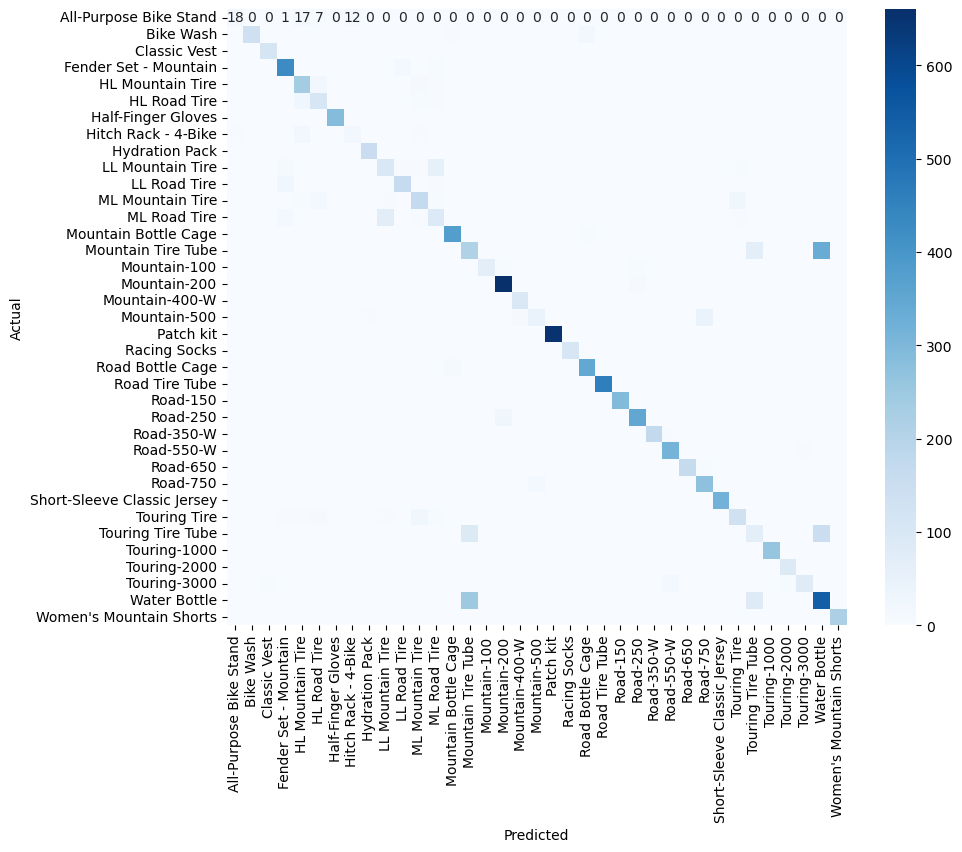

In [90]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()